# [Instagram Page Screen Shots in 5 Category](https://www.kaggle.com/datasets/bahramjannesarr/instagram-page-screen-shots-in-5-category)

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt # visualization
import random
import os
%matplotlib inline
import shutil
import zipfile

import torch
import torch.nn as nn # neural network
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision.models as models
import torch.optim as optim

In [2]:
try:
    from torchsummary import summary # 깔끔하게 pytorch 출력
    import splitfolders
except:
    !pip install torchsummary
    from torchsummary import summary
    !pip install split-folders tdqm  # progress bar도 함께 보여주기 위해 tdqm 같이 써줌
    import splitfolders

## 2. DEVICE Setting

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650 with Max-Q Design'

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(' PyTorch version : ', torch.__version__, '\n', 'Device : ', DEVICE)

# 난수 지정
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True 

 PyTorch version :  1.12.1 
 Device :  cuda


## 3. PARAMETER Setting

In [5]:
BATCH_SIZE = 64
EPOCHS = 10
TEST_RATIO = 0.2
learning_rate = 0.0001

## 4. Download Data From Kaggle

- Create New token
- move kaggle.json to ~\.kaggle\kaggle.json

In [6]:
# !pip install kaggle
!pip show kaggle

Name: kaggle
Version: 1.5.12
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: c:\users\kim juii\appdata\roaming\python\python39\site-packages
Requires: tqdm, requests, python-dateutil, python-slugify, urllib3, six, certifi
Required-by: 


In [7]:
os.environ['KAGGLE_USERNAME'] = 'kkkkkkkiii' # your-kaggle-username
os.environ['KAGGLE_KEY'] = 'adf7a4ef846bfd6a1b21002d7b3d0b5a' # your-kaggle-api-key

In [8]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [9]:
api.dataset_download_files('bahramjannesarr/instagram-page-screen-shots-in-5-category', path="./dataset")

In [10]:
root = os.getcwd()
dataset_dir = os.path.join(root, 'dataset')

zipfile_name = os.listdir(dataset_dir)[0]
zipfile_name

'instagram-page-screen-shots-in-5-category.zip'

In [11]:
zipfile_path = os.path.join(dataset_dir, zipfile_name)

zipfile.ZipFile(zipfile_path).extractall(path='./dataset/')

In [12]:
os.listdir(dataset_dir)

['beauty',
 'family',
 'fashion',
 'fitness',
 'food',
 'instagram-page-screen-shots-in-5-category.zip']

In [13]:
splitfolders.ratio(dataset_dir, output='./split_dataset', seed=1, ratio=(1-TEST_RATIO, TEST_RATIO))

Copying files: 3770 files [00:04, 809.81 files/s]


In [14]:
train_dataset_dir = os.path.join(root, 'split_dataset', 'train')
test_dataset_dir = os.path.join(root, 'split_dataset', 'val')

In [15]:
train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=transforms.ToTensor())

# train_dataset_size = int(TEST_RATIO * len(dataset))
# test_dataset_size = len(dataset) - train_dataset_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_dataset_size, test_dataset_size])

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_dataset:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_dataset)
stds /= len(train_dataset)
    
print(f'Means: {means}')
print(f'STDs: {stds}')

Means: tensor([0.6395, 0.5844, 0.5506])
STDs: tensor([0.2851, 0.2930, 0.3085])


In [16]:
img_size = 224
trained_means = [0.6395, 0.5844, 0.5506]
trained_stds= [0.2851, 0.2930, 0.3085]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size), # image를 (224, 224) 사이즈로 변경하되, 변경되는 image pixel 값은 random으로 선택
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=trained_means, std=trained_stds) 
    # ToTensor()형태로 전환된 image에 대해 또 다른 Normalization을 진행 (mean, std 필요한데 R, G, B 순으로 mean, std Normalization 적용)
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=trained_means, std=trained_stds) 
])

dataset = datasets.ImageFolder(root=dataset_dir, transform=transforms.ToTensor())

train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dataset_dir, transform=test_transforms)
num_of_classes = len(dataset.classes)

print('Classes : ', dataset.classes)
print('Num of Classes : ', num_of_classes)
print('Total Data Size : ', len(dataset))
print('Train Data Size : ', len(train_dataset))
print('Test Data Size : ', len(test_dataset))

Classes :  ['beauty', 'family', 'fashion', 'fitness', 'food']
Num of Classes :  5
Total Data Size :  3770
Train Data Size :  3015
Test Data Size :  755


### Mini-Batch

In [17]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_iteration = len(train_loader)
test_iteration = len(test_loader)
print('Train Iteration : ', train_iteration); print('Test Iteration : ', test_iteration)

Train Iteration :  47
Test Iteration :  12


## 5. Check Data

In [18]:
for (X_train, y_train) in train_loader:
  print('X_train : ', X_train.size(), ' type : ', X_train.type())  # 64개의 RGB (channel 3개)로 이뤄진 224*224 이미지 데이터 [BATCH_SIZE, channel, height, width]
  print('y_train : ', y_train.size(), ' type : ', y_train.type())
  break

X_train :  torch.Size([64, 3, 224, 224])  type :  torch.FloatTensor
y_train :  torch.Size([64])  type :  torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


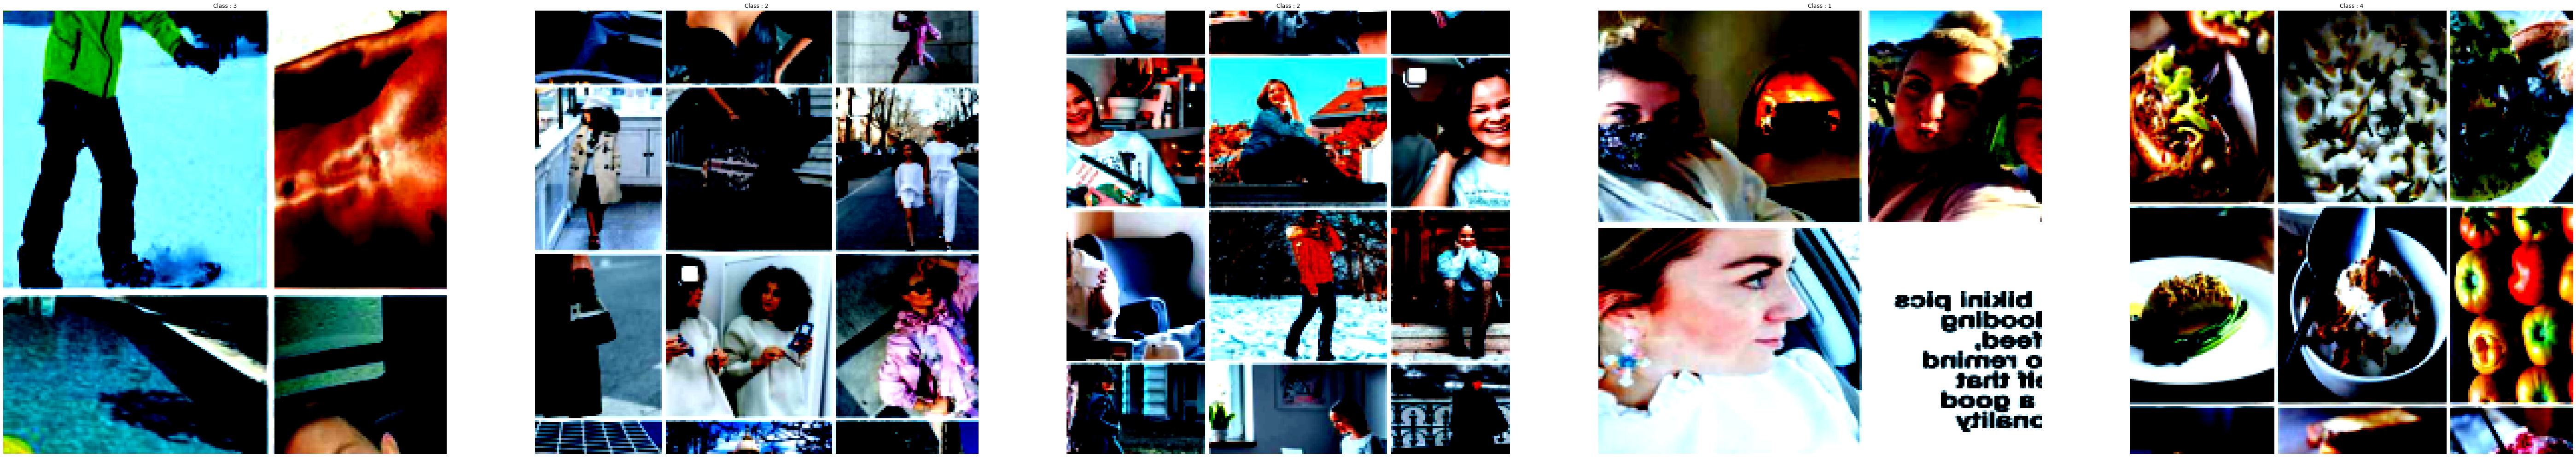

In [19]:
plt.figure(figsize=(100, 100))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0))) # [BATCH_SIZE, Channel, Height, Width]를 시각화하기 위해
    plt.title('Class : ' + str(y_train[i].item()))

## 6. Define Model - ResNet50

Total data가 3770장으로, 많은 편은 아니기 때문에 Transfer Learning 진행

![](https://blog.kakaocdn.net/dn/cjoceg/btq0ulXxaaM/dkAS3aQHHg6BU4ReLgxsFk/img.png)

ResNet-18,34은 Residual Block 사용
ResNet-50은 BottleNeck 사용

![](https://github.com/Pseudo-Lab/pytorch-guide/blob/main/img/03-1.png?raw=true)

In [20]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups
        
        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [21]:
model = models.resnet50(pretrained=True).to(DEVICE)

C:\ProgramData\Miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_of_classes)
model = model.to(DEVICE)

## Optimizer / Objective Function Setting

In [23]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrpssEntropyLoss()

print(model)

AttributeError: module 'torch.nn' has no attribute 'CrpssEntropyLoss'

## Training